Core routines for modeling is found in the file `modeling.py`. This notebook is for sample testing and analytics only.

In [1]:
%pylab inline
from matplotlib import pyplot as plt
from workflow.data import *
from workflow.features import *
import pandas as pd
import numpy as np
import seaborn as sns

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

plt.tight_layout
plt.rcParams.update({'font.size': 22})
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
figure(figsize(10,7))
cmap= sns.color_palette('Set1')
sns.set_palette(cmap)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# connect to SQL database

username = 'psam071'
host = 'localhost'
dbname = 'citibike'

db = create_engine('postgres://%s%s/%s' % (username,host,dbname))
con = None

con = psycopg2.connect(database = dbname, user = username, host = host)

# Querying and Transforming Data

In [3]:
# query stations from 2015 that existed at the beginning of the data
# collecting period
query_stations2015 = """
    SELECT DISTINCT a.id, name, lat, long, neighborhood, borough
    FROM features a
    LEFT JOIN stations b ON a.id = b.id
    LEFT JOIN neighborhoods c on a.id = c.id
    WHERE a.date = '2015-03-01'
        AND borough = 'Manhattan'
    ORDER BY a.id;
"""

stations2015 = pd.read_sql_query(query_stations2015, con)
stations2015 = stations2015.dropna()

In [4]:
# most unbalanced stations
query_unbal_stations = """
    SELECT a.id, abs(a.bikes_in - a.bikes_out) as flux,
                 abs(a.rbikes_in - a.rbikes_out) as rflux,
                 a.bikes_in, a.bikes_out,                                 
            c.name, neighborhood, borough, long, lat
    FROM   (SELECT id, min(date) as date, sum(bikes_out) as bikes_out, 
                sum(bikes_in) as bikes_in,
                sum(rbikes_in) as rbikes_in, sum(rbikes_out) as rbikes_out
            FROM features
            GROUP BY id) a
    JOIN neighborhoods b ON a.id = b.id
    JOIN stations c on b.id = c.id
    WHERE date = '2015-03-01'
    ORDER BY rflux DESC
    LIMIT 100;
"""

# make query and filter stations that existed at the beginning of the data collection phase
df_unbal_stations = pd.read_sql_query(query_unbal_stations, con)
# df_unbal_stations = df_unbal_stations[df_unbal_stations.id.isin(stations2015.id)]

In [5]:
# save list of top 100 unbalanced stations to pickle file for webapp
df_unbal_stations.to_pickle('websitetools/stations.pickle')

The purpose of this series of queries is to pull up 100 Citibike stations that have the most rebalancing traffic, because those stations will tend to have the most interesting activity.

In [6]:
def dfcol_into_sqllist(df, col):
    """
    convert a column in a pandas dataframe to a string for sql queries
    """
    listy = list(df[col].unique())
    listy = listy[0:10]
    return "(" + str(listy)[1:-1] + ")"

string_of_unbal_stations = str(list(df_unbal_stations.id.unique()))[1:-1]
list_of_unbal_stations = list(df_unbal_stations.id)
df_unbal_stations.id.unique().shape

(100,)

The point of the function above is to make sure the list is in a form a SQL query could see. A list of stations `[a,b,c]` would not be readable in a SQL query because it is not in a string format. It needs to be converted into something like `('a', 'b', 'c')`.

In [7]:
# look at the patterns for the rebalanced stations
# make sure tot_docks > 0 (especially when calculating bikes available)

ids_to_see = dfcol_into_sqllist(df_unbal_stations, 'id')

query = """
    SELECT a.id, a.date, a.hour, bikes_out, bikes_in, dayofweek, month, is_weekday,
            is_holiday, rbikes_out, rbikes_in, tot_docks, avail_bikes, avail_docks,
            precip, temp, long, lat, neighborhood, borough
    FROM features a
    LEFT JOIN weather b ON a.date = b.date AND a.hour = b.hour
    LEFT JOIN stations c ON a.id = c.id
    LEFT JOIN neighborhoods d ON a.id = d.id
    WHERE a.id in {}
        AND tot_docks > 0
        AND borough = 'Manhattan'
    ORDER BY a.id, a.date, a.hour;
""".format(ids_to_see)

df = pd.read_sql_query(query, con)
df.date = pd.to_datetime(df.date)

In [8]:
# make new features (percentages)
df = new_features(df)

In [9]:
# split data into 2015 (train) and 2016 (test) data
# 
data_cols = ['id', 'long', 'lat', 'hour', 'month', 'dayofweek',
             'is_weekday', 
             'is_holiday', 'precip', 'temp', 'pct_avail_bikes', 
             'pct_avail_docks']

hist_cols = ['mean_flux', 'yest_flux', 'last_week_flux']

df2015 = df[(df.date.dt.year == 2015)]
df2016 = df[(df.date.dt.year == 2016)]

# Prepare pipeline

### TPOT Regressor

### RandomForestRegressor

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

params = [{'min_samples_leaf': [12, 14, 16],
          'min_samples_split': [6, 8, 10],
          'max_features': [0.85,0.95,1.]}]


X_train = df2015[data_cols]
y_train = df2015.pct_flux

X_test = df2016[data_cols]
y_test = df2016.pct_flux

reg = RandomForestRegressor(min_samples_leaf=16, min_samples_split=6, max_features = 0.95,
                            n_jobs=-1)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)


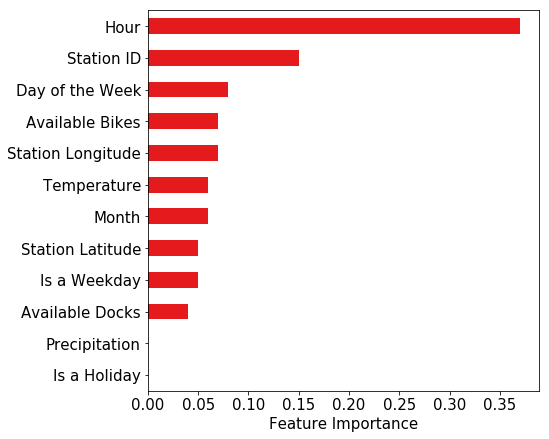

In [11]:
# create a feature importances plot
reg.feature_importances_.round(2)
importances = list(reg.feature_importances_.round(2))

features_dict = {}
for importance, col in zip(importances, data_cols):
    features_dict[col] = importance

feature_imp = pd.Series(features_dict)
values_to_plot = feature_imp.sort_values()
values_to_plot.rename(index = {'id':'Station ID',
                                 'hour': 'Hour',
                                 'pct_avail_bikes': 'Available Bikes',
                                 'dayofweek': 'Day of the Week',
                                 'is_weekday': 'Is a Weekday',
                                 'temp': 'Temperature',
                                 'precip': 'Precipitation',
                                'month': 'Month',
                              'lat': 'Station Latitude',
                              'long': 'Station Longitude',
                              'pct_avail_docks': 'Available Docks',
                              'is_holiday': 'Is a Holiday'}, inplace = True)
values_to_plot.plot(kind = 'barh', figsize=(7,7))
xlabel('Feature Importance', fontsize = 15)

# Test Model

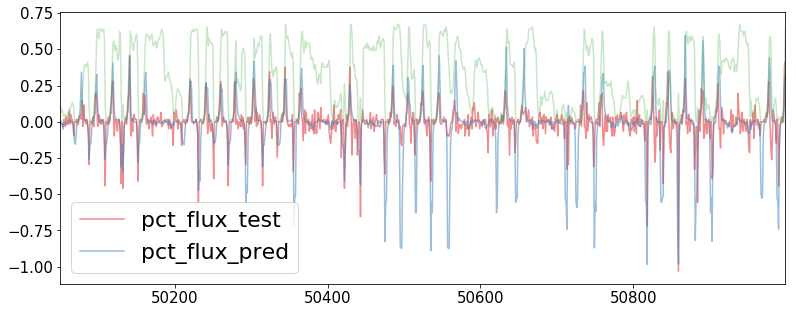

In [12]:
def merge_pred_test(pred, y_test):
    tests = pd.DataFrame()
    tests['pct_flux_test'] = y_test.reset_index().pct_flux
    tests['pct_flux_pred'] = pred
    return tests

def plot_pred_test(test,X_test):
    tests.iloc[50050:51000].plot(figsize = (13,5), alpha = 0.5)
    X_test.reset_index().iloc[50050:51000].pct_avail_bikes.plot(alpha = 0.3)
    
   
tests = merge_pred_test(pred, y_test)
plot_pred_test(tests, X_test)

In [13]:
def merge_test_pred(X, y, pred):
    pred_series = pd.Series(pred)
    X = X.reset_index()
    X['pct_flux_test'] = y.reset_index().pct_flux
    X['pct_flux_pred'] = pred_series
    return X

df_compare = merge_test_pred(X_test, y_test, pred)
    

In [25]:
list(station_name)

['W 41 St & 8 Ave']

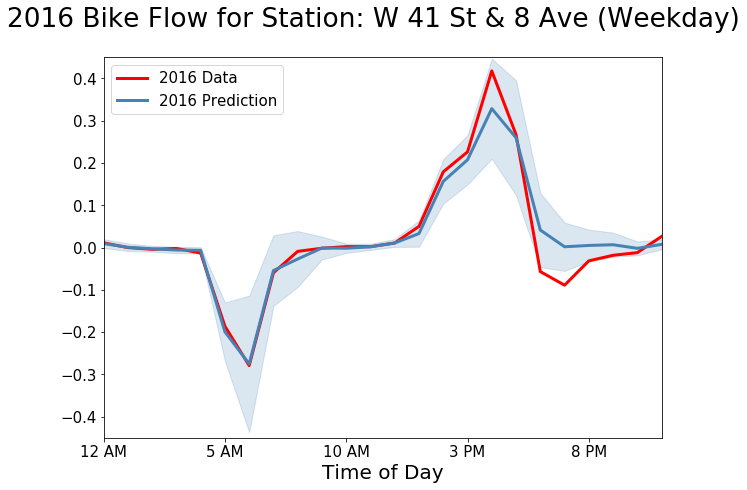

In [27]:
# create flow plot with errors for a specific station

# make appropriate groupings and filterings to extract station data
cols  = ['pct_flux_pred', 'pct_flux_test', 'hour']
weekday = 1
dock_id = 477
grps = df_compare.groupby(['id','is_weekday', 'hour']).mean().reset_index()
grps_std = df_compare.groupby(['id','is_weekday', 'hour']).std().reset_index()
cond = (grps.is_weekday ==  weekday) & (grps.id == dock_id)

station_name = list(stations2015[stations2015.id == dock_id].name)[0]

# create hourly profiles with error estimates
hr_profile = grps[cond][cols].set_index('hour')
hr_profile_errors = grps_std[cond][cols].set_index('hour')

x = hr_profile.pct_flux_pred
error = hr_profile_errors.pct_flux_pred

# create plot elements
ax = hr_profile.pct_flux_test.plot(label = '2016 Data', 
                                 linewidth = 3, 
                                 color = 'red')
x.plot(linewidth = 3, label = '2016 Prediction', 
       color = 'steelblue')
fill_between(list(x.index), list(x - error), list(x + error), 
             alpha = 0.2, color = 'steelblue')

labels = ['12 AM', '5 AM', '10 AM', '3 PM', '8 PM']
ax.set_xticklabels(labels)

xlabel('Time of Day', size = 20)
legend(loc = 2, prop = {'size':15})
ylim([-0.45,0.45])
suptitle('2016 Bike Flow for Station: {} (Weekday)'.format(station_name))

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

def scoring_metrics(predicted, labeled):
    mse = mean_squared_error(predicted, labeled)
    r2 = r2_score(predicted, labeled)
    
    print 'MSE: {}'.format(mse)
    print 'R2: {}'.format(r2)
    
    
scoring_metrics(hr_profile.pct_flux_pred, hr_profile.pct_flux_test)

MSE: 0.00125547471605
R2: 0.915139577922


# Miscellaneous Plotting

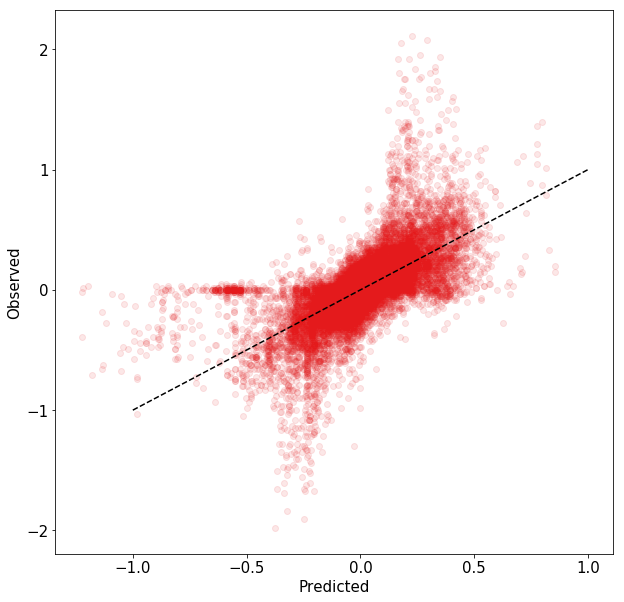

In [28]:
# prediction/observation plot

line = linspace(-1,1, num = 50)

fig = plt.figure(figsize = (10,10))
pl = fig.add_subplot(111)
pl.scatter(pred, y_test, alpha = 0.1)
pl.plot(line, line, c = 'k', linestyle = '--')
xlabel('Predicted',fontsize = 15)
ylabel('Observed',fontsize = 15)


In [29]:
# queries the entire features table to calculate pct_flux
ids_to_see = dfcol_into_sqllist(df_unbal_stations, 'id')

query = """
    SELECT a.id, a.date, a.hour, bikes_out, bikes_in, dayofweek, month, is_weekday,
            is_holiday, rebal_net_flux, tot_docks, avail_bikes, avail_docks,
            precip, snow, temp, c.long, c.lat
    FROM features a
    LEFT JOIN weather b ON a.date = b.date AND a.hour = b.hour
    LEFT JOIN stations c ON a.id = c.id
    WHERE tot_docks > 0 AND a.id in {}
    ORDER BY a.id, a.date, a.hour;
""".format(ids_to_see)

df = pd.read_sql_query(query, con)
df.date = pd.to_datetime(df.date)
df = new_features(df)

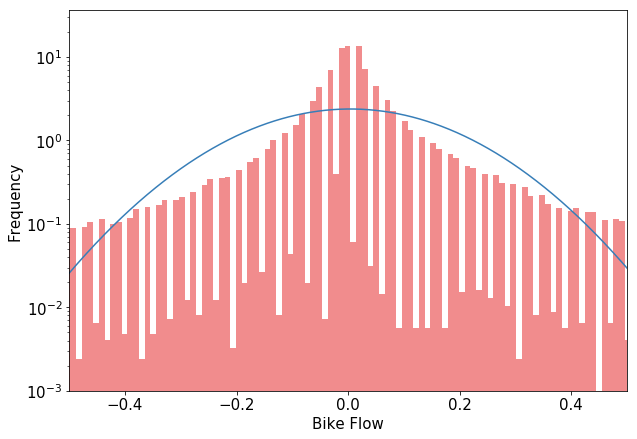

In [30]:
# histogram of pct_flux compared to normal distribution

from scipy.stats import norm
x_axis = np.arange(-1,1,0.001)

df.pct_flux.plot(kind = 'hist', logy = True, bins=400, normed = True, alpha = 0.5)
plot(x_axis, norm.pdf(x_axis, df.pct_flux.mean(), df.pct_flux.std()))
xlim([-0.5,0.5])
ylim([0.001, None])
xlabel('Bike Flow', fontsize = 15)
ylabel('Frequency', fontsize = 15)

In [32]:
stations2015[stations2015.id == dock_id].name.iloc[0]

'W 41 St & 8 Ave'

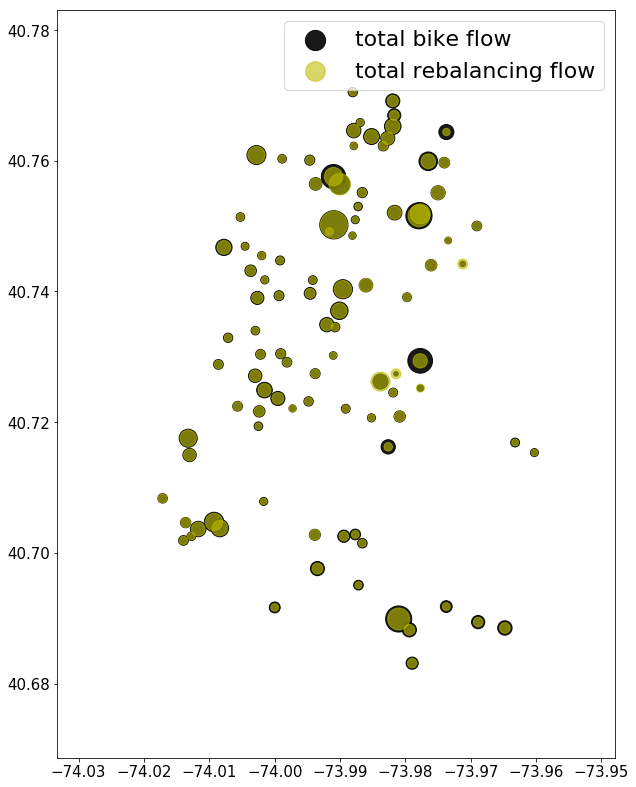

In [43]:
# map plot of flow activity vs. rebalancing activity

fig = plt.figure(figsize = (10,15))
pl1 = fig.add_subplot(111)
pl1.scatter(df_unbal_stations.long, df_unbal_stations.lat,
           s = df_unbal_stations.flux/25, color = 'k', alpha=0.9,
           label = 'total bike flow')
pl1.scatter(df_unbal_stations.long, df_unbal_stations.lat,
           s = df_unbal_stations.rflux/25, color = 'y', alpha=0.6,
           label = 'total rebalancing flow')

plt.axes().set_aspect('equal')
plt.legend(loc='best')

## Sample Queries

In [ ]:
# find the most active stations by bikes_out
query_stations_out = """
    SELECT a.id, bikes_out, c.name, neighborhood, borough
    FROM   (SELECT id, sum(bikes_out) as bikes_out
            FROM features
            GROUP BY id) a
    JOIN neighborhoods b ON a.id = b.id
    JOIN stations c on b.id = c.id
    ORDER BY bikes_out DESC;
"""

df_stations_out = pd.read_sql_query(query_stations_out, con)
df_stations_out.head(20)

In [ ]:
# find the most active stations by bikes_in
query_stations_in = """
    SELECT a.id, bikes_in, c.name, neighborhood, borough
    FROM   (SELECT id, sum(bikes_in) as bikes_in
            FROM features
            GROUP BY id) a
    JOIN neighborhoods b ON a.id = b.id
    JOIN stations c ON b.id = c.id
    ORDER BY bikes_in DESC;
"""

df_stations_in = pd.read_sql_query(query_stations_in, con)
df_stations_in.head(20)

In [ ]:
# find the most active neighborhoods by bikes_out
query_hoods_out = """
        SELECT sum(a.bikes_out) as bikes_out, 
                b.neighborhood, b.borough
        FROM features a
        JOIN neighborhoods b on a.id = b.id
        GROUP BY borough, neighborhood
        ORDER BY bikes_out DESC;
"""

df_hoods_out = pd.read_sql_query(query_hoods_out, con)
df_hoods_out.head(20)

In [ ]:
# find the most active neighborhoods by bikes_in
query_hoods_in = """
        SELECT sum(a.bikes_in) as bikes_in, 
                b.neighborhood, b.borough
        FROM features a
        JOIN neighborhoods b on a.id = b.id
        GROUP BY borough, neighborhood
        ORDER BY bikes_in DESC;
"""

df_hoods_in = pd.read_sql_query(query_hoods_in, con)
df_hoods_in.head(20)

In [ ]:
# find the most unbalanced neighborhoods
query_hoods_in = """
        SELECT sum(a.bikes_in - a.bikes_out) as flux, 
                b.neighborhood, b.borough
        FROM features a
        JOIN neighborhoods b on a.id = b.id
        GROUP BY borough, neighborhood
        ORDER BY flux DESC;
"""

df_hoods_in = pd.read_sql_query(query_hoods_in, con)
df_hoods_in.head(20)